# EECS 731 Project 3 - Clustering Movies

The goal of this project was to take the [MovieLens](https://grouplens.org/datasets/movielens/) data set and use clustering to create a recomendation system based around those movies. That is, given a movie I enjoyed, I should be able to find other similar movies that I should watch next. I took two approaches to feature engineering on the data and in each approach I used three different clustering algorithms--DBSCAN, Mean Shift, and K Means. Overall, the results seemed pretty good when inspecting certian movies I was familar with and seeing what other movies the models decided were similar. However, it seemed like the predictors were relying a bit more on genre than I would've liked. I attempted to combat this in the second approach by normalizing values so that they were in a similar range to that of the one hot encoded genres.

In [1]:
%matplotlib inline

import pandas
import numpy as np
from tqdm.notebook import tqdm

tqdm.pandas()

In [2]:
raw_movies = pandas.read_csv("../data/large/movies.csv")
raw_tags = pandas.read_csv("../data/large/tags.csv")
raw_ratings = pandas.read_csv("../data/large/ratings.csv")

raw_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
raw_tags.tag.values

array(['epic', 'Medieval', 'sci-fi', ..., 'pacing', 'plot',
       'Sylvester Stallone'], dtype=object)

In [4]:
raw_ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [5]:
raw_ratings.describe()

,userId,movieId,rating,timestamp
count,2.775344e+07,2.775344e+07,2.775344e+07,2.775344e+07
mean,1.419420e+05,1.848800e+04,3.530445e+00,1.193122e+09
std,8.170740e+04,3.510263e+04,1.066353e+00,2.160482e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,7.117600e+04,1.097000e+03,3.000000e+00,9.986053e+08
50%,1.420220e+05,2.716000e+03,3.500000e+00,1.174256e+09
75%,2.124590e+05,7.150000e+03,4.000000e+00,1.422744e+09
max,2.832280e+05,1.938860e+05,5.000000e+00,1.537945e+09


In [6]:
def genre_to_list(row):
    return row['genres'].split('|')

raw_movies['genre_list'] = raw_movies.apply(genre_to_list, axis=1)

raw_movies.head()

,movieId,title,genres,genre_list
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),Comedy,[Comedy]


In [7]:
mean_ratings = raw_ratings.groupby(['movieId']).rating.mean()

def collect_ratings(row):
    try:
        return mean_ratings[row.movieId]
    except:
        return np.nan

raw_movies['ratings'] = raw_movies.progress_apply(collect_ratings, axis=1)

raw_movies.head()

,movieId,title,genres,genre_list,ratings
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",3.886649
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",3.246583
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",3.173981
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]",2.874540
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],3.077291


## Average Rating per Movie

So, this is actually somewhat interesting as the ratings themselves are centered around 3.5, but once you collect those ratings per movie they end up positively skewed. There's also this interesting phenomena in that the whole number ratings seem to be more commmon than the half point ratings (e.g. 3 is way more common than 3.5)

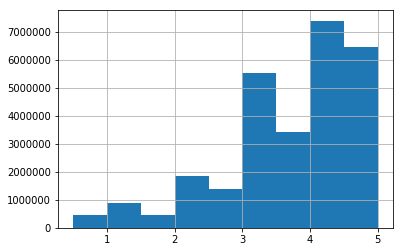

In [8]:
raw_ratings.rating.hist(bins=9)

## One Hot Encoding Genre

Next, using the list of genres we one hot encode them so that we can actually model based on the resulting vector space. The main issue with one hot encoding like this is that it assumes that all genres are equally distant from each other when in reality some are more similar than others. For example, I'd bet that horror and thriller are more similar than say horror and children. 

In [9]:
genres = [["Action"],
    ["Adventure"],
    ["Animation"],
    ["Children"],
    ["Comedy"],
    ["Crime"],
    ["Documentary"],
    ["Drama"],
    ["Fantasy"],
    ["Film-Noir"],
    ["Horror"],
    ["Musical"],
    ["Mystery"],
    ["Romance"],
    ["Sci-Fi"],
    ["Thriller"],
    ["War"],
    ["Western"],
    ["IMAX"]]

from sklearn.preprocessing import OneHotEncoder

# This is so that an empty list of genres or a genre of '(no genres listed)' both get treated as a vector 0
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(genres)

def genre_to_vec(row):
    x = np.zeros(len(genres))
    for genre in row.genre_list:
        x = np.add(x, enc.transform([[genre]]).toarray())
    return x.tolist()

raw_movies['genre_vec'] = raw_movies.progress_apply(genre_to_vec, axis=1)
raw_movies.genre_vec.head()

0    [[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...
1    [[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0,...
2    [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...
3    [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...
4    [[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...
Name: genre_vec, dtype: object

## Model Input Preperation

We first remove all of the rows with nan values, this is all the rows that didn't have a corresponding rating. This seems better than trying to assign an arbitrary rating to the movie since then we're adding data to the dataset that's not really realistic.

For this first model, we create the input by combining the one hot encoded vectors with the mean ratings calculated above.

In [10]:
rated_movies = raw_movies.dropna()

Z = np.array(rated_movies.genre_vec.tolist())
Z = Z.reshape(Z.shape[0], Z.shape[2])
X = np.array(rated_movies.ratings.tolist()).reshape(Z.shape[0], 1)

X = np.append(Z, X, 1)

X[0]

array([0.        , 1.        , 1.        , 1.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 3.88664943])

## DBSCAN

We first run DBSCAN. The epsilon value choosen here is due to the already close one hot encoded genre list. Using the default value of 0.5 results in clusters that, to me, seem a bit too large and that don't really reflect similarity between movies. Below you can see the number of movies that failed to be clustered. Around 1% of the total dataset.

In [11]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.25, n_jobs=-1).fit_predict(X)

clustered_movies = rated_movies.copy()
clustered_movies['cluster'] = clustering

clustered_movies.loc[clustered_movies.cluster == -1].count()

movieId       4046
title         4046
genres        4046
genre_list    4046
ratings       4046
genre_vec     4046
cluster       4046
dtype: int64

Although a fairly abritrary example, I think this cluster shows a good example of movies that I would consider similar. However, as alluded to above, this is a bit heavy on focusing on genre which I'll address later.

In [12]:
clustered_movies.loc[clustered_movies.cluster == 0]

,movieId,title,genres,genre_list,ratings,genre_vec,cluster
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",3.246583,"[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",0
59,60,"Indian in the Cupboard, The (1995)",Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",3.071241,"[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",0
124,126,"NeverEnding Story III, The (1994)",Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",2.344783,"[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",0
990,1009,Escape to Witch Mountain (1975),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",3.143728,"[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",0
1960,2043,Darby O'Gill and the Little People (1959),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",3.284622,"[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",0
2010,2093,Return to Oz (1985),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",2.957143,"[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",0
2078,2161,"NeverEnding Story, The (1984)",Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",3.500161,"[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",0
2079,2162,"NeverEnding Story II: The Next Chapter, The (1...",Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",2.488164,"[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",0
2315,2399,Santa Claus: The Movie (1985),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",2.750977,"[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",0
4801,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",3.674892,"[[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0,...",0


## Mean Shift

I next ran Mean Shift. As you can see from the distribution of the cluster values, most of the movies fell within one cluster, which I would say is not a great result as I would not consider almost every movie similar to the every other movie.

In [13]:
from sklearn.cluster import MeanShift

ms_clustering = MeanShift(n_jobs=-1).fit_predict(X)

clustered_movies['ms_clustering'] = ms_clustering

clustered_movies['ms_clustering'].describe()

count    53889.000000
mean         0.010837
std          0.155061
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: ms_clustering, dtype: float64

## KMeans

K was choosen by looking at the number of clusters generated by DBSCAN since the rough shape and size of those clusteres seemed good. As you can see below, an again completly arbitrary cluster, seems like a good selection of movies and it's interesting to compare this cluster value to that of DBSCAN and see that KMeans picked up some values that DBSCAN couldn't cluster as well as has a similar combination of movies.

In [14]:
from sklearn.cluster import KMeans

km_clustering = KMeans(n_jobs=-1, n_clusters=400).fit_predict(X)

clustered_movies['km_clustering'] = km_clustering

clustered_movies.km_clustering.describe()

count    53889.000000
mean       143.624524
std        115.804875
min          0.000000
25%         35.000000
50%        118.000000
75%        234.000000
max        399.000000
Name: km_clustering, dtype: float64

In [15]:
clustered_movies.loc[clustered_movies.km_clustering == 9]

,movieId,title,genres,genre_list,ratings,genre_vec,cluster,ms_clustering,km_clustering
71,72,Kicking and Screaming (1995),Comedy|Drama,"[Comedy, Drama]",3.484633,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...",30,0,9
94,96,In the Bleak Midwinter (1995),Comedy|Drama,"[Comedy, Drama]",3.690661,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...",30,0,9
154,156,Blue in the Face (1995),Comedy|Drama,"[Comedy, Drama]",3.532726,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...",30,0,9
169,171,Jeffrey (1995),Comedy|Drama,"[Comedy, Drama]",3.598294,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...",30,0,9
203,205,Unstrung Heroes (1995),Comedy|Drama,"[Comedy, Drama]",3.505435,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...",30,0,9
232,235,Ed Wood (1994),Comedy|Drama,"[Comedy, Drama]",3.658249,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...",30,0,9
269,272,"Madness of King George, The (1994)",Comedy|Drama,"[Comedy, Drama]",3.736970,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...",30,0,9
319,322,Swimming with Sharks (1995),Comedy|Drama,"[Comedy, Drama]",3.678912,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...",30,0,9
320,324,"Sum of Us, The (1994)",Comedy|Drama,"[Comedy, Drama]",3.693648,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...",30,0,9
341,345,"Adventures of Priscilla, Queen of the Desert, ...",Comedy|Drama,"[Comedy, Drama]",3.624714,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...",30,0,9


## Normalized Values and Year

For the next, more engineered dataset, I wanted to both normalize the rating to be between 0 and 1 so that it was on a similar scale to the one hot encoded features as well as add the year the movie was released. Again, I normalized the year as best I could so that it would fall between 0 and 1. In this case, I thought year could be a good feature since when I personally think of similar movies, I also consider movies that came out around the same time. 

I also removed all the movies with nan values from this dataset as that contains movies where I couldn't easily parse the year (this only occurs in a few movies that happen to also have parenthesis in the title).

In [16]:
def get_normalized_year(row):
    title = row.title
    try:
        year = int(title[title.find("(")+1:title.find(")")])
        return (2020 - year) / (2020 - 1900)
    except:
        return np.nan

yeared_movies = raw_movies.copy()
yeared_movies['year'] = yeared_movies.progress_apply(get_normalized_year, axis=1)
yeared_movies = yeared_movies.dropna()

In [17]:
yeared_movies.ratings = yeared_movies.ratings / 5

yeared_movies.ratings.describe()

count    48280.000000
mean         0.609071
std          0.149939
min          0.100000
25%          0.530000
50%          0.624275
75%          0.700000
max          1.000000
Name: ratings, dtype: float64

## Creating input data for the models

Again, I combine the genre information with the above ratings and year to create the input for this set of models.

In [18]:
Z = np.array(yeared_movies.genre_vec.tolist())
Z = Z.reshape(Z.shape[0], Z.shape[2])
X = np.array(yeared_movies.ratings.tolist()).reshape(Z.shape[0], 1)
A = np.array(yeared_movies.year.tolist()).reshape(Z.shape[0], 1)

X = np.append(Z, X, 1)
X = np.append(X, A, 1)

X[0]

array([0.        , 1.        , 1.        , 1.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.77732989,
       0.20833333])

## DBSCAN

I again started with DBSCAN, using the same epsilon as before for the same reason. As you can see from this run, we had about half as many movies that failed to be clustered. You can also see an arbitrary example of the movies that were considered similar, which again seemed like a pretty accurate collection.

In [19]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.25, n_jobs=-1).fit_predict(X)

clustered_movies = rated_movies.copy()
yeared_movies['db_cluster'] = clustering

yeared_movies.loc[yeared_movies.db_cluster == -1].count()

movieId       2324
title         2324
genres        2324
genre_list    2324
ratings       2324
genre_vec     2324
year          2324
db_cluster    2324
dtype: int64

In [20]:
yeared_movies.loc[yeared_movies.db_cluster == 0]

,movieId,title,genres,genre_list,ratings,genre_vec,year,db_cluster
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",0.777330,"[[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...",0.208333,0
2210,2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",0.647140,"[[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...",0.183333,0
3028,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",0.761995,"[[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...",0.175000,0
3664,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",0.441339,"[[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...",0.166667,0
3923,4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",0.719439,"[[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...",0.166667,0
4791,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",0.770670,"[[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...",0.158333,0
10130,33463,DuckTales: The Movie - Treasure of the Lost La...,Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",0.679290,"[[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...",0.250000,0
11009,45074,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",0.514371,"[[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...",0.116667,0
11899,53121,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",0.589905,"[[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...",0.108333,0
13378,65577,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",0.600399,"[[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0,...",0.100000,0


In [21]:
yeared_movies.db_cluster.max()

410

## Mean Shift

Next, I again ran Mean Shift. As you can see from the distribution of cluster labels, the results aren't great since there are only 3 clusters with almost all of the movies being thrown in the first cluster. This mimics the results from Mean Shift on the earlier dataset too.

In [22]:
from sklearn.cluster import MeanShift

ms_clustering = MeanShift(n_jobs=-1).fit_predict(X)

yeared_movies['ms_clustering'] = ms_clustering

yeared_movies['ms_clustering'].describe()

count    48280.000000
mean         0.000746
std          0.038611
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: ms_clustering, dtype: float64

In [23]:
yeared_movies.loc[yeared_movies.ms_clustering == 2]

,movieId,title,genres,genre_list,ratings,genre_vec,year,db_cluster,ms_clustering
4923,5018,Motorama (1991),Adventure|Comedy|Crime|Drama|Fantasy|Mystery|S...,"[Adventure, Comedy, Crime, Drama, Fantasy, Mys...",0.625532,"[[0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0,...",0.241667,-1,2
9494,27781,Svidd Neger (2003),Comedy|Crime|Drama|Horror|Mystery|Romance|Thri...,"[Comedy, Crime, Drama, Horror, Mystery, Romanc...",0.572727,"[[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0,...",0.141667,-1,2
9803,31921,"Seven-Per-Cent Solution, The (1976)",Adventure|Comedy|Crime|Drama|Mystery|Thriller,"[Adventure, Comedy, Crime, Drama, Mystery, Thr...",0.670787,"[[0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0,...",0.366667,-1,2
13271,64645,The Wrecking Crew (1968),Action|Adventure|Comedy|Crime|Drama|Thriller,"[Action, Adventure, Comedy, Crime, Drama, Thri...",0.500000,"[[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0,...",0.433333,-1,2
13731,68411,Black Magic (1944),Comedy|Crime|Drama|Horror|Mystery|Thriller,"[Comedy, Crime, Drama, Horror, Mystery, Thriller]",0.550000,"[[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0,...",0.633333,-1,2
16105,81132,Rubber (2010),Action|Adventure|Comedy|Crime|Drama|Film-Noir|...,"[Action, Adventure, Comedy, Crime, Drama, Film...",0.584559,"[[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0,...",0.083333,-1,2
16560,83266,Kaho Naa... Pyaar Hai (2000),Action|Adventure|Comedy|Drama|Mystery|Romance|...,"[Action, Adventure, Comedy, Drama, Mystery, Ro...",0.622222,"[[1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,...",0.166667,-1,2
18447,91542,Sherlock Holmes: A Game of Shadows (2011),Action|Adventure|Comedy|Crime|Mystery|Thriller,"[Action, Adventure, Comedy, Crime, Mystery, Th...",0.746522,"[[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0,...",0.075000,-1,2
24934,115333,Charlie Chan in Panama (1940),Adventure|Comedy|Crime|Drama|Mystery|Thriller,"[Adventure, Comedy, Crime, Drama, Mystery, Thr...",0.600000,"[[0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0,...",0.666667,-1,2
25399,116676,Game of Swords (2005),Action|Adventure|Crime|Drama|Mystery|Thriller,"[Action, Adventure, Crime, Drama, Mystery, Thr...",0.650000,"[[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0,...",0.125000,-1,2


## K-Means

Finally, I again ran K-Means, using the same value of 400 for K since that was around the number of clusters that DBSCAN found. As with the previous dataset, it's interesting to see how K-Means produced clusters that were similar to DBSCAN, but with a few extras that DBSCAN failed to put into a cluster.

In [24]:
from sklearn.cluster import KMeans

km_clustering = KMeans(n_jobs=-1, n_clusters=400).fit_predict(X)

yeared_movies['km_clustering'] = km_clustering

yeared_movies.km_clustering.describe()

count    48280.000000
mean       135.507229
std        121.556592
min          0.000000
25%         24.000000
50%         94.000000
75%        210.000000
max        399.000000
Name: km_clustering, dtype: float64

In [25]:
yeared_movies.loc[yeared_movies.km_clustering == 123]

,movieId,title,genres,genre_list,ratings,genre_vec,year,db_cluster,ms_clustering,km_clustering
343,347,Bitter Moon (1992),Drama|Film-Noir|Romance,"[Drama, Film-Noir, Romance]",0.687407,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",0.233333,-1,0,123
2528,2612,Mildred Pierce (1945),Drama|Film-Noir,"[Drama, Film-Noir]",0.786360,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",0.625000,239,0,123
3035,3121,"Hitch-Hiker, The (1953)",Drama|Film-Noir,"[Drama, Film-Noir]",0.687709,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",0.558333,239,0,123
3872,3965,"Strange Love of Martha Ivers, The (1946)",Drama|Film-Noir,"[Drama, Film-Noir]",0.728794,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",0.616667,239,0,123
4338,4432,Sweet Smell of Success (1957),Drama|Film-Noir,"[Drama, Film-Noir]",0.810466,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",0.525000,239,0,123
4922,5017,"Big Heat, The (1953)",Drama|Film-Noir,"[Drama, Film-Noir]",0.792752,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",0.558333,239,0,123
5193,5289,Body and Soul (1947),Drama|Film-Noir,"[Drama, Film-Noir]",0.759848,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",0.608333,239,0,123
5966,6064,"Harder They Fall, The (1956)",Drama|Film-Noir,"[Drama, Film-Noir]",0.714444,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",0.533333,239,0,123
7712,8236,While the City Sleeps (1956),Drama|Film-Noir,"[Drama, Film-Noir]",0.684615,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",0.533333,239,0,123
7806,8420,Possessed (1947),Drama|Film-Noir,"[Drama, Film-Noir]",0.723333,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",0.608333,239,0,123


## Final Thoughts

I wanted to try and use the tags dataset, but from previous experience with trying to embed words, I knew that it would make the space signifigantly longer, leading to drastically longer running times for the above models. Additionally, given the lack luster results I'd seen using FastText before, I'd want to use a more robust embedding, but that would've taken a lot more time than I had for this project.

I also want to look more into Mean Shift since the results were objectively terrible, but looking at the documentation from scikit learn, I didn't see any parameters that would've helped.